In [1]:
import numpy as np
import matplotlib.pyplot as plt
import imageio
import matplotlib
import cv2
import glob

from panorama_to_pinhole import *

In [161]:
import open3d as o3d
from pyntcloud import PyntCloud

In [2]:
plt.style.use('dark_background')
matplotlib.rcParams['figure.figsize'] = (12, 8)

# 1. Load panorama

load the panorama image and its corresponding depth data

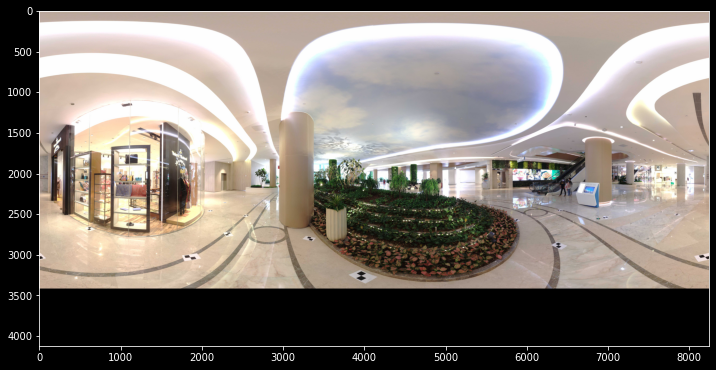

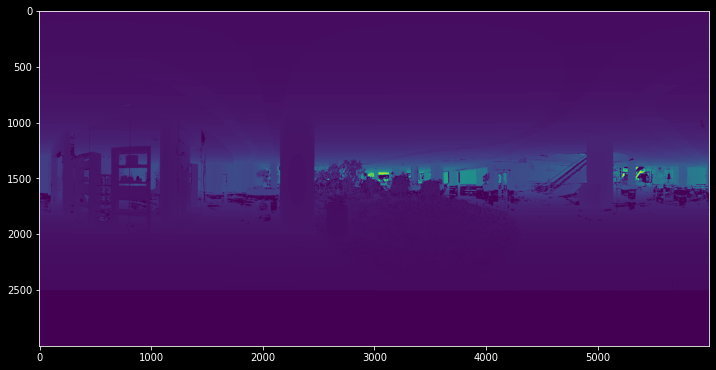

In [3]:
test_image = "pano_1.jpg" 
depth_path = "depth_1.npy"

panorama_depth = np.load(depth_path)
panorama_img = imageio.imread(test_image)[:, :, :3]
panorama_sampler = panorama_to_sampler(panorama_img)

plt.figure()
plt.imshow(panorama_img)
plt.figure()
plt.imshow(panorama_depth)

## 1.1 Projected to point cloud

In [341]:
def panorama_to_cloud(image, depth, interval=1):
    image_uni = cv2.resize(image, (depth.shape[1], depth.shape[0]))
    #print(image_uni.shape, depth.shape)
    width = depth.shape[1]
    height = depth.shape[0]
    points = []
    colors = []
    
    
    for i in range(0,depth.shape[0],interval):
        pitch = (i - height/2) * np.pi / height 
        for j in range(0,depth.shape[1],interval):
            if(depth[i,j] < 0.1):
                continue
            yaw = (j - width/2) * 2 * np.pi / width
            sphere = np.array([np.cos(pitch)*np.sin(yaw) , np.sin(pitch), np.cos(pitch)*np.cos(yaw)])
            point_3d = sphere * depth[i,j]
            points.append(point_3d)
            colors.append(image_uni[i,j,:])
            
    return points, colors

In [347]:
points_full, colors_full = panorama_to_cloud(panorama_img, panorama_depth)

In [342]:
points_sub, colors_sub = panorama_to_cloud(panorama_img, panorama_depth,10)

In [343]:
point_cloud_o3d_2 = o3d.geometry.PointCloud()
point_cloud_o3d_2.points = o3d.utility.Vector3dVector(np.asarray(points_sub))
point_cloud_o3d_2.colors = o3d.utility.Vector3dVector(np.asarray(colors_sub)/255)

o3d.visualization.draw_geometries([point_cloud_o3d_2])

![image cloud test](images/pts_test.png)

## 1.2 Transform to pinhole camera model images

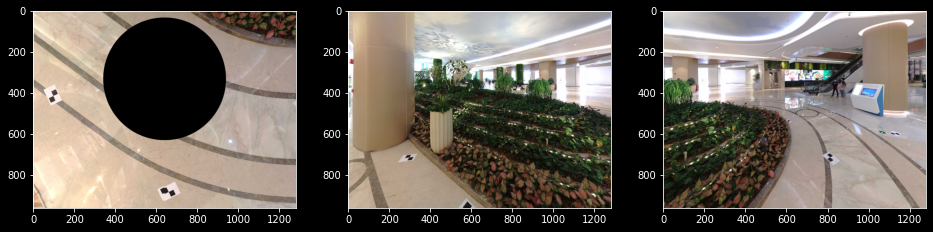

In [202]:
res = (1280, 2000)
focal = 500
width = res[0]*480/640
offset = 150

image_pinhole = panorama_to_pinhole(panorama_sampler, res, focal, [-90, 0, 0])
image_show = image_pinhole[int(res[1]/2-width/2)+offset:int(res[1]/2+width/2)+offset,:,:]

plt.figure(figsize=(16,8))
plt.subplot(131)
plt.imshow(image_show)

image_pinhole = panorama_to_pinhole(panorama_sampler, res, focal, [0, 0, 0])
image_show = image_pinhole[int(res[1]/2-width/2)+offset:int(res[1]/2+width/2)+offset,:,:]

plt.subplot(132)
plt.imshow(image_show)

image_pinhole = panorama_to_pinhole(panorama_sampler, res, focal, [0, 80, 0])
image_show = image_pinhole[int(res[1]/2-width/2)+offset:int(res[1]/2+width/2)+offset,:,:]

plt.subplot(133)
plt.imshow(image_show)

## 1.3 Project the corresponding pinhole model depth image

In [5]:
def camera_fov(fx, width):
    side = width * 0.5 / fx
    return np.arctan2(side, 1) * 360 / np.pi

In [7]:
def color_jet(depth_image):
    max_d = np.max(depth_image)
    #print(max_d)
    depth_jet = np.zeros([depth_image.shape[0],depth_image.shape[1],3]).astype(np.uint8)
    
    norm_depth = depth_image / max_d
    norm_depth = norm_depth.reshape([depth_image.shape[0],depth_image.shape[1]])
    depth_jet[:,:,0] = norm_depth * 255
    depth_jet[:,:,2] = 255 - depth_jet[:,:,0]
    return depth_jet

In [302]:
def get_depth(cloud_pt, camera_mtx, image_w_h, P):
    image = np.zeros(image_w_h)
    cam_R = P[0:3,0:3]
    cam_t = P[0:3, 3].reshape([3,1])
    #print(cam_R,cam_t)
    for i in range(len(cloud_pt)):
        pt = cloud_pt[i].reshape([3,1])
        pt_camera = np.dot( camera_mtx, np.dot(cam_R, pt) + cam_t )
        if(pt_camera[2] < 0.1):
            continue
            
        img_u = int(pt_camera[1]/pt_camera[2])
        img_v = int(pt_camera[0]/pt_camera[2])
        
        if img_u < 0 or img_u > image_w_h[0]-1:
            continue
        if img_v < 0 or img_v > image_w_h[1]-1:
            continue 
        
        image[img_u,img_v] = pt_camera[2]
    return image

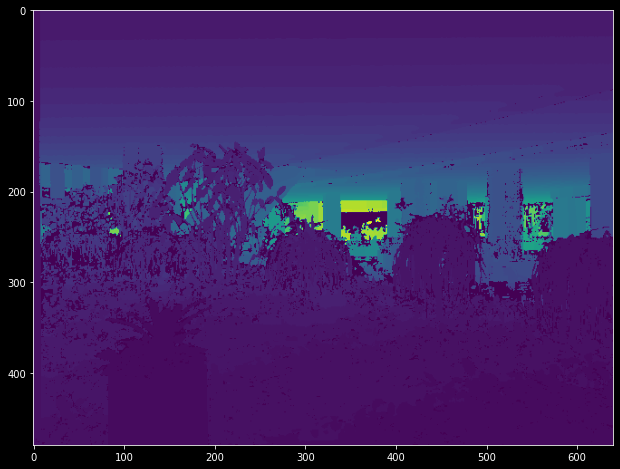

In [297]:
plt.imshow(get_depth(points_full, camera2, (480,640),np.eye(4)))

# 2. Project to pinhole image for feature extraction

use a range of pinhole camera

In [10]:
def sift_to_rootsift(des):
    eps=1e-7
    des /= (des.sum(axis=1, keepdims=True) + eps)
    des = np.sqrt(des)
    return des

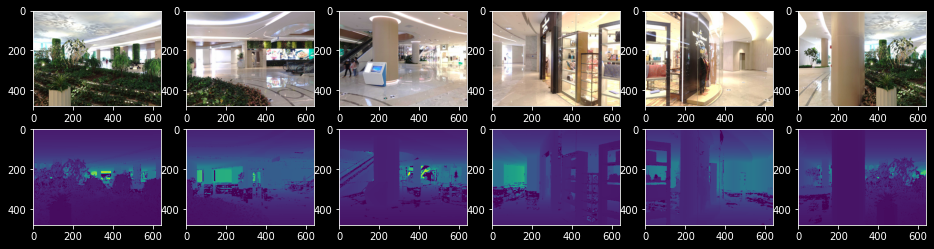

In [303]:
res = (640, 480)
focal = 500
width = res[0]*480/640
offset = 0

camera2 = np.array([
    [focal, 0, res[0]/2],
    [0,focal, res[1]/2],
    [0,0,1]
])

fov = camera_fov(focal, res[0])
num_image = int(np.ceil(360 / fov))

sift = cv2.xfeatures2d.SIFT_create()

save_path = "pinhole_test/"

pinhole_images = []
pinhole_kps = []
pinhole_dess = []
pinhole_depths = []
pinhole_pose = []

plt.figure(figsize=(16,4))
for i in range(num_image):
    angle = fov * i;
    
    rot_angles_rad = np.deg2rad(np.array([0, angle, 0]))
    R = R_cam_to_world(*rot_angles_rad)
    pinhole_pose.append(R)
    
    image_pinhole = panorama_to_pinhole(panorama_sampler, res, focal, [0, angle, 0])
    image_show = image_pinhole[int(res[1]/2-width/2)+offset:int(res[1]/2+width/2)+offset,:,:]

    #depth_pinhole = panorama_to_pinhole_depth(panorama_depth_sampler, res, focal, [0, angle, 0])
    #depth_show = depth_pinhole[int(res[1]/2-width/2)+offset:int(res[1]/2+width/2)+offset,:,:]
    pose = np.eye(4)
    pose[0:3,0:3] = np.transpose(R)
    depth_show = get_depth(points, camera2, (480,640), pose)

    pinhole_images.append(image_show)
    
    #feature extraction
    kp, des = sift.detectAndCompute(image_show, None)
    des = sift_to_rootsift(des)
    depths = np.zeros(len(kp))
    
    pinhole_kps.append(kp)
    pinhole_dess.append(des)
    pinhole_depths.append(depths)
    
    # draw sift
    for k in range(len(kp)):
        pt = (int(kp[k].pt[0]), int(kp[k].pt[1]))
        #cv2.circle(image_show,pt,3, (255,0,0))
        depths[k] = depth_show[pt[1], pt[0]]
    
    cv2.imwrite(save_path+str(i)+"_rgb.png", image_show)
    cv2.imwrite(save_path+str(i)+"_dep.png", depth_show)
    np.save(save_path+str(i)+"_dep.npy", depth_show)
    
    plt.subplot(2,num_image,(i+1))
    plt.imshow(image_show)
    plt.subplot(2,num_image,(i+1+num_image))
    plt.imshow(depth_show)

In [320]:
def pinhole_to_cloud(kps, deps, image, camera_mtx):
    points = []
    colors = []
    
    camera_mtx_inv = np.linalg.inv(camera_mtx)
    #print(camera_mtx_inv)
    for i in range(len(kps)):
        if(deps[i] < 0.5):
            continue
        pt = np.array([kps[i].pt[0], kps[i].pt[1],1]).reshape([3,1])
        pt_3d = np.dot(camera_mtx_inv , pt) * deps[i]        
        points.append(pt_3d.reshape(3))
        colors.append(image[int(kps[i].pt[1]), int(kps[i].pt[0]), :])
            
    return points, colors

In [322]:
idx = 0
pts, cols = pinhole_to_cloud(pinhole_kps[idx], pinhole_depths[idx], pinhole_images[idx], camera2)

point_cloud_o3d_2 = o3d.geometry.PointCloud()
point_cloud_o3d_2.points = o3d.utility.Vector3dVector(np.asarray(pts))

colors = [[0,0,255] for i in range(len(pts))]
point_cloud_o3d_2.colors = o3d.utility.Vector3dVector(np.asarray(cols)/255)

o3d.visualization.draw_geometries([point_cloud_o3d_2])

# 3. Test image

In [307]:
test_image_path = "test_images"
test_images = glob.glob(test_image_path+"/*.png")
print("load", len(test_images), "test images")

load 15 test images


In [386]:
def pose_estimation_with_mathes(kp1, kp2, depth2, pose2, matches, camera1, camera2):
    MIN_MATCH_COUNT = 10
    if len(matches) < MIN_MATCH_COUNT:
        return False, -1, -1
    
    src_pts = np.float32([ kp1[m[0].queryIdx].pt for m in matches ]).reshape(-1,1,2)
    
    dst_pts = np.float32([ kp2[m[0].trainIdx].pt for m in matches ]).reshape(-1,1,2)
    dst_depth = np.float32([ depth2[m[0].trainIdx] for m in matches ])
    
    camera2_inv = np.linalg.inv(camera2)
    
    cam_R = pose2[0:3,0:3]
    cam_t = pose2[0:3, 3].reshape([3,1])

    point_2d = []
    point_3d = []
    for i in range(dst_pts.shape[0]):
        if(dst_depth[i] < 0.1):
            continue
        pt = np.array([dst_pts[i,0,1], dst_pts[i,0,1],1]).reshape([3,1])
        pt_3d = np.dot(camera2_inv , pt) * dst_depth[i]        
        pt_3d_world = np.dot(cam_R, pt_3d) + cam_t
        
        point_3d.append(pt_3d_world.reshape(3))
        point_2d.append([src_pts[i,0,1], src_pts[i,0,1]])
    
    if(len(point_2d) < MIN_MATCH_COUNT):
        return False, -1, -1
    
    (found, r, t, mask ) = cv2.solvePnPRansac(np.asarray(point_3d,np.float32), 
                                              np.asarray(point_2d,np.float32), camera1, np.zeros(4))
    P = np.eye(4)
    if found:
        rot,_ = cv2.Rodrigues(r)
        trans = t[:,0]
        P[0:3,0:3] = rot
        P[0:3,3] = trans
    return found , P, np.sum(mask)

In [392]:
camera1 = np.array([
    [500.207825, 0, 319.501862],
    [0,499.880157, 240.560242],
    [0,0,1]
])


# return P : world to camera
def match_image(image, pinhole_images, pinhole_kps, pinhole_dess, pinhole_depths):
    #image = cv2.imread(image_file)
    #image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    sift = cv2.xfeatures2d.SIFT_create()
    kp, des = sift.detectAndCompute(image, None)
    des = sift_to_rootsift(des)
        
    # draw sift
    for k in range(len(kp)):
        pt = (int(kp[k].pt[0]), int(kp[k].pt[1]))
        cv2.circle(image,pt,3, (0,255,0))
    
    MIN_MATCH_COUNT = 10
    # FLANN init
    FLANN_INDEX_KDTREE = 0
    index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
    search_params = dict(checks=50)

    flann = cv2.FlannBasedMatcher(index_params,search_params)
    
    num_image = len(pinhole_images)
    show_images = []
    found = False
    P = np.eye(4)
    best_num_matches = -1
    for i in range(num_image):
        matches = flann.knnMatch(des,pinhole_dess[i],k=2)

        good_matches = []
        for m,n in matches:
            if m.distance < 0.75*n.distance:
                good_matches.append(m)
                
        if len(good_matches) > MIN_MATCH_COUNT:
            src_pts = np.float32([ kp[m.queryIdx].pt for m in good_matches ]).reshape(-1,1,2)
            dst_pts = np.float32([ pinhole_kps[i][m.trainIdx].pt for m in good_matches ]).reshape(-1,1,2)
            H, mask = cv2.findFundamentalMat(src_pts, dst_pts, cv2.RANSAC,5.0)
                
            #print(mask.shape, len(good_matches), mask.sum())
            good_matches_fin = []
            for k in range(len(mask)):
                if(mask[k]):
                    good_matches_fin.append([good_matches[k]])
            
            if(len(good_matches_fin) < MIN_MATCH_COUNT):
                continue
            
            pose_2 = np.eye(4)
            pose_2[0:3,0:3] = pinhole_pose[i]
            found, P_t, n_pnp_matches = pose_estimation_with_mathes(kp, pinhole_kps[i], pinhole_depths[i], pose_2,
                                                   good_matches_fin,
                                                   camera1, camera2)
            if(n_pnp_matches > best_num_matches):
                P = P_t
                best_num_matches = n_pnp_matches
            
            im_matches = cv2.drawMatchesKnn(image,kp,pinhole_images[i],pinhole_kps[i],
                                            good_matches_fin,None,flags=2)
            show_images.append(im_matches)
            
            #print(P)
        
    if(len(show_images) > 0):
        num_show = len(show_images)
        #print(image_file)
        plt.figure(figsize=(12,5*num_show))
        for i in range(len(show_images)):
            plt.subplot(num_show,1,(i+1))
            plt.imshow(show_images[i])
            
    return found, P

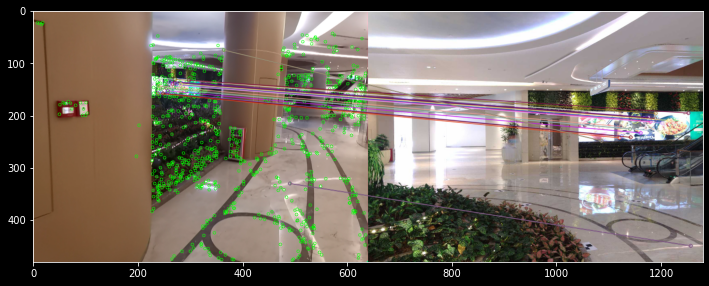

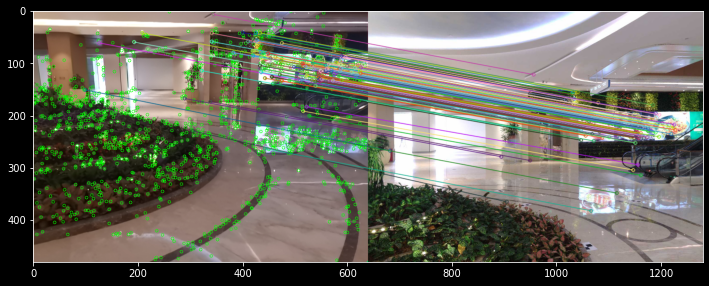

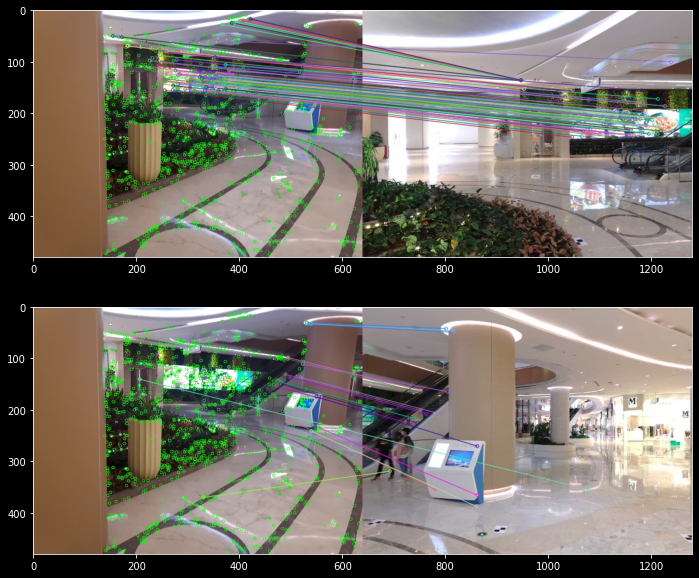

In [393]:
succ_id = []
succ_T = []
for i in range(len(test_images)):
    image = cv2.imread(test_images[i])
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    found, P = match_image(image, pinhole_images, pinhole_kps, pinhole_dess, pinhole_depths)
    if(found):
        succ_id.append(i)
        succ_T.append(P)

### project the depth image to the estimated pose

In [338]:
def project_depth_to_image(cloud_pt, cloud_color, camera_mtx, image_w_h, P):
    image = np.zeros(image_w_h, np.uint8)
    cam_R = P[0:3,0:3]
    cam_t = P[0:3, 3].reshape([3,1])
    #print(cam_R,cam_t)
    for i in range(0, len(cloud_pt), 100):
        pt = cloud_pt[i].reshape([3,1])
        pt_camera = np.dot( camera_mtx, np.dot(cam_R, pt) + cam_t )
        if(pt_camera[2] < 0.1):
            continue
            
        img_u = int(pt_camera[1]/pt_camera[2])
        img_v = int(pt_camera[0]/pt_camera[2])
        
        if img_u < 0 or img_u > image_w_h[0]-1:
            continue
        if img_v < 0 or img_v > image_w_h[1]-1:
            continue 
        
        #image[img_u,img_v,:] = cloud_color[i]
        color = (int(cloud_color[i][0]), int(cloud_color[i][1]), int(cloud_color[i][2]))
        cv2.circle(image,(img_v,img_u),3, color,-1)
    return image

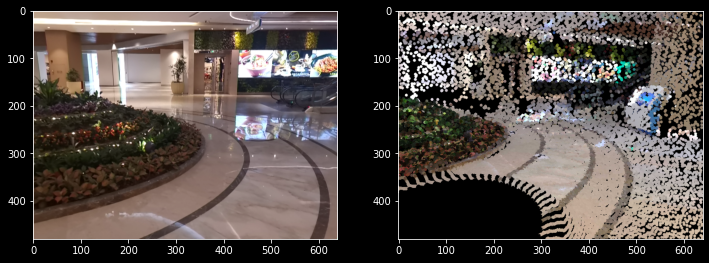

In [394]:
idx = 1
sim_image = project_depth_to_image(points_full, colors_full, camera1, [480, 640,3] , succ_T[idx])
image = cv2.imread(test_images[succ_id[idx]])
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.subplot(121)
plt.imshow(image)
plt.subplot(122)
plt.imshow(sim_image)